# Module 3 - Final Assignment - RAG Agent with LangChain and Mistral-7B

This notebook is the final assignment for the course "Foundation of Large Language Models: Tools, Techniques and Applications". It presents an example of how to implement a RAG agent with LangChain and Mistral-7B.

An agent is a program that interacts with a user. It has a main task, which is to answer questions, and can use tools. For this example, the tool is a search engine. The agent will use the search engine to find information that is not in its prior knowledge.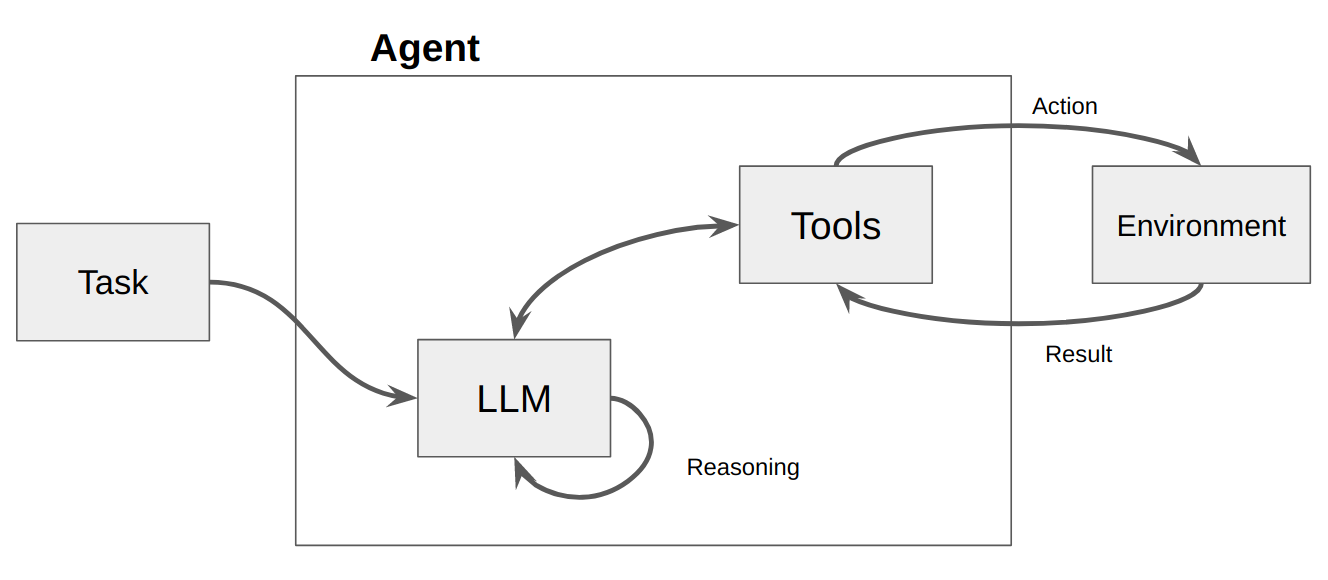


# Lab Assignment

For the lab assignment, search for **`TODO:`** in the cells and write your code to accomplish the task.

# Installing required packages

For this example, we will install the following libraries:

**`transformers`**:

Transformers is an open-source library for NLP developed by Hugging Face. It provides state-of-the-art pre-trained models for various NLP tasks, such as text classification, sentiment analysis, question-answering, named entity recognition, etc.

**`langchain`**:

Langchain is a library that facilitates the building of language model applications. It is designed to be used alongside models like those provided by the transformers library, and it offers tools and functionalities to streamline the integration of language models into various applications. This can include tasks like conversational agents, text generation, and more advanced NLP operations.

**`accelerate`**:

Accelerate is a library created by Hugging Face, designed to simplify the use of hardware acceleration (such as GPUs and TPUs) in machine learning projects. It provides an easy-to-use interface for distributing training and inference tasks across multiple devices, helping to significantly speed up the processing time for complex models. This library is particularly useful when working with large models or datasets, as it efficiently manages the hardware resources to optimize performance.

**`bitsandbytes`**:

BitsAndBytes is a library designed to optimize the training of neural networks on modern GPUs. It offers efficient implementations of 8-bit optimizers, which significantly reduce the memory footprint of model parameters and gradients. This reduction in memory usage enables training larger models or using larger batch sizes within the same memory constraints.

**`unstructured`**:

`unstructured` is a Python library designed for working with unstructured data in NLP. This library provides tools and functions to handle, process, and analyze data that does not fit into conventional row and column structures, such as text, images, and audio.


**`faiss-gpu`**:

`faiss-gpu` is a library primarily developed by Facebook AI Research (FAIR) for efficient similarity search and clustering of dense vectors. It is particularly optimized for use on GPUs, which allows it to perform large-scale similarity searches and clustering operations at high speed.


**`sentence-transformers`**:

`sentence-transformers` is a library developed by UKPLab, which provides a wide range of pre-trained models for computing sentence embeddings. It also offers a simple interface for fine-tuning these models on custom datasets, which can be used to improve the performance of the models on specific tasks.


In [2]:
!pip install langchain
!pip install accelerate
!pip install transformers
!pip install bitsandbytes
!pip install unstructured
!pip install sentence-transformers
!pip install langchain-community
!pip install faiss-gpu # For CUDA 7.5+ Supported GPU's.
# OR
# !pip install faiss-cpu # For CPU Installation
!pip install grandalf


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


# Setting the device

In this example, we will use a GPU to speed up the processing of our model. GPUs (Graphics Processing Units) are specialized processors that are optimized for performing large-scale computations in parallel. By using a GPU, we can accelerate the training and inference of a machine learning model, which can significantly reduce the time required to complete these tasks.

Before we begin, we need to check whether a GPU is available and select it as the default device for our PyTorch operations. This is because PyTorch can use either a CPU or a GPU to perform computations, and by default, it will use the CPU.

For using a GPU in Google Colab:
1. Click on the "Runtime" menu at the top of the screen.
2. From the dropdown menu, click on "Change runtime type".
3. In the popup window that appears, select "GPU" as the hardware accelerator.
4. Click on the "Save" button.

That's it! Now you can use the GPU for faster computations in your notebook.

In [3]:
!nvidia-smi

Sun Jun 22 22:21:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   38C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import libraries

In the following code cell we import all the libraries at once. We will use the libraries as we go along.

In [4]:
import torch

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from typing import Annotated

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredURLLoader
from langchain.chains import RetrievalQA

from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import ReActSingleInputOutputParser
from langchain.tools.render import render_text_description
from langchain.agents import tool
from langchain.prompts import PromptTemplate
from langchain.tools import  Tool
from langchain_core.tools import StructuredTool


from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')

# Download and load Mistral-7B-Instruct

In this example, we will use Mistral-7B-Instruc, a language model with 7 billion parameters. Before loading the model, we have to define the quantization configuration. The quantization configuration is a dictionary that contains the quantization parameters for each layer. The quantization parameters are defined in the `BitsAndBytesConfig` class. The `BitsAndBytesConfig` class contains the following parameters:

- `load_in_4bit`: If True, the model will be loaded in 4-bit. If False, the model will be loaded in 8-bit.
- `bnb_4bit_compute_dtype`: The compute dtype for 4-bit quantization. The default value is `torch.float16`.
- `bnb_4bit_quant_type`: The quantization type for 4-bit quantization. The default value is `nf4`.
- `bnb_4bit_use_double_quant`: If True, the model will be quantized twice. The first quantization is done with the `bnb_4bit_compute_dtype` and the second quantization is done with `torch.float16`. The default value is `True`.


In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

Now, we can load the model and the tokenizer. The `trust_remote_code` parameter is set to `True` to allow the model to be loaded from the HuggingFace model hub. The `device_map` parameter is set to `auto` to allow the model to be loaded on the GPU if available. The `quantization_config` parameter is set to the quantization configuration defined above. We also set the `torch_dtype` parameter to `torch.float16` to load the model in 16-bit. The `use_fast` parameter is set to `True` to load the tokenizer in fast mode. Finally, we set the `pad_token` to the `eos_token` to allow the model to generate sequences of any length.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
from google.colab import userdata

access_token = userdata.get("HF_TOKEN")

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config,
    token=access_token
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Then, we can define the generation configuration.
- The `max_new_tokens` parameter is set to 1024 to allow the model to generate sequences of up to 1024 tokens.
- The `temperature` parameter is set to 0.0001 to allow the model to generate sequences with a very low temperature.
- The `top_p` parameter is set to 0.95 to allow the model to generate sequences with a very high top-p.
- The `do_sample` parameter is set to `True` to allow the model to generate sequences with sampling. - The `repetition_penalty` parameter is set to 1.15 to allow the model to generate sequences with a high repetition penalty.
- Finally, we set the `return_full_text` parameter to `True` to allow the model to return the full generated text.

In [7]:
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

generation_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True
)

Device set to use cuda:0


# Testing the model

Now, we can test the model. First, let's define the LLM object using the `HuggingFacePipeline` from `langchain`. We do this by passing the pipeline defined above to the `pipeline` parameter.

In [8]:
llm = HuggingFacePipeline(
    pipeline=generation_pipeline,
)

Now, let's test the model on a simple query.

In [9]:
query = "Explain the difference between ChatGPT and open LLMs in a couple of lines."
result = llm(query)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

<b>Explain the difference between ChatGPT and open LLMs in a couple of lines.</b>

<p>Explain the difference between ChatGPT and open LLMs in a couple of lines.

ChatGPT is a specific model trained by OpenAI, while open LLMs (large language models) are a general term that refer to any large language model, regardless of who trained it. Open LLMs are often used for tasks such as text generation and language translation, while ChatGPT is specifically designed for conversational AI.</p>

We can see that the model is able to generate a coherent answer to the query. Now, let's test the model on a query about **Ayrton Senna**, a Brazilian racing driver who won the Formula One World Drivers' Championship three times.

In [10]:
query = "Who is Ayrton Senna?"
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

<b>Who is Ayrton Senna?</b>

<p>Who is Ayrton Senna?
Ayrton Senna was a Brazilian professional race car driver who is widely considered to be one of the greatest Formula One drivers of all time. He won the Formula One World Championship three times, in 1988, 1990, and 1991, and was the first driver to win the title in a car with an active rear suspension. Senna was also known for his aggressive driving style and his feud with rival Michael Schumacher during the late 1990s. He died tragically in a crash during the 1994 San Marino Grand Prix at the age of 45.</p>

As we can see, **the model generated a generic answer**. This may indicate that the model needs information about the topic to generate a better answer.

# Retrieval Augmented Generation

To solve this problem, we can use retrieval augmented generation. Retrieval augmented generation is a technique that uses a retrieval model to retrieve relevant information from a knowledge base and then uses a language model to generate a coherent answer.

In this example, we will use `BAAI/bge-base-en-v1.5` as the retrieval model. `bge` is short for BAAI general embedding. This model is a dense retriever that uses a pre-trained language model to encode the query and the documents.

First, let's load the model using the `HuggingFaceEmbeddings` from `langchain`. We do this by passing the model name to the `model_name` parameter. We also set the `model_kwargs` parameter to `{"device": "cuda"}` to load the model on the GPU if available. Finally, we set the `encode_kwargs` parameter to `{"normalize_embeddings": True}` to normalize the embeddings.

In [11]:
encoder = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-base-en-v1.5",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now, let's load the documents. We do this by `UnstructuredURLLoader` from the `unstructured` module. We pass the URLs of the documents to the `urls` parameter.

As this example is about **Ayrton Senna**, we will load two documents about him. The first document from the Formula 1 website, and the second document is from the Senna website.

You can use this example to load your own documents. Just replace the URLs with the URLs of your documents.

In [12]:
urls = [
    "https://www.formula1.com/en/drivers/hall-of-fame/Ayrton_Senna.html",
    "https://en.wikipedia.org/wiki/Ayrton_Senna",
    "https://www.britannica.com/biography/Ayrton-Senna"
]

loader = UnstructuredURLLoader(urls=urls)
documents = loader.load()

We cannot pass the documents directly to the retrieval model. We have to split the documents into chunks. We do this by using the `RecursiveCharacterTextSplitter` from the `langchain` module. We pass the documents to the `documents` parameter. We set the `chunk_size` parameter to 512 to split the documents into chunks of 512 characters. We set the `chunk_overlap` parameter to 64 to allow the chunks to overlap by 64 characters. You can experiment with these parameters to see which values work best for your use case later.

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts_chunks = text_splitter.split_documents(documents)

len(texts_chunks)

197

For searching in the documents, we have to create a vector store. We do this by using the `FAISS` from the `langchain.vectorstores` module. FAISS is a library for efficient similarity search and clustering of dense vectors.

- We pass the chunks of text to the `documents` parameter.
- We pass the embeddings of the chunks of text to the `embeddings` parameter.


In [14]:
from langchain.vectorstores import FAISS

db = FAISS.from_documents(texts_chunks, encoder)

Now, let's use the LLM in combination with the retrieval model to generate a coherent answer to the query about **Ayrton Senna**. First, let's define the instruction template. This template contains two placeholders: `{context}` and `{question}`. The `{context}` placeholder will be replaced with the retrieved documents. The `{question}` placeholder will be replaced with the query.


In [15]:
template = """<s>[INST]
You are a useful assistant.

{context}

{question} [/INST]
"""

We use the `PromptTemplate` from the `langchain` module to define the prompt. We pass the template to the `template` parameter. We set the `input_variables` parameter to `["context", "question"]` to allow the template to use the `context` and `question` variables.

In [16]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

Now, let's define the retrieval QA object using the `RetrievalQA` from `langchain`.
- We do this by passing the LLM to the `llm` parameter.
- We pass the retrieval model to the `retriever` parameter.
- We set the `return_source_documents` parameter to `True` to allow the retrieval model to return the source documents.
- We pass the prompt to the `chain_type_kwargs` parameter.
- We set the `chain_type` parameter to `stuff` to allow the retrieval model to retrieve relevant information from the documents.  Learn more abou `stuff` document chain [here](https://python.langchain.com/docs/modules/chains/document/stuff).
- We set the `search_kwargs` parameter to `{"k": 2}` to allow the retrieval model to retrieve the top 2 documents.

In [17]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Create a retriever from the FAISS database
retriever = db.as_retriever(search_kwargs={"k": 2})

# Define the RAG chain using LCEL
qa_chain = (
    {"context": retriever | RunnablePassthrough(), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print(qa_chain.get_graph().draw_ascii())

              +---------------------------------+           
              | Parallel<context,question>Input |           
              +---------------------------------+           
                    ****               ****                 
                 ***                       ***              
               **                             ***           
+----------------------+                         **         
| VectorStoreRetriever |                          *         
+----------------------+                          *         
            *                                     *         
            *                                     *         
            *                                     *         
    +-------------+                        +-------------+  
    | Passthrough |                        | Passthrough |  
    +-------------+*                       +-------------+  
                    ****               ****                 
                        

In [18]:
query = "Who is Ayrton Senna?"
result_ = qa_chain.invoke(query)
# the result contains the original prompt along with answer, we are just striping it out
prompt, answer = '\n'.join(result_.split('\n')[:-1]), result_.split('\n')[-1]


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<b>{answer}</b>"))

<b>Who is Ayrton Senna?</b>

<b>Ayrton Senna was a Brazilian racing driver who competed in Formula One from 1984 to 1994. He won three Formula One World Drivers' Championship titles with McLaren, and at the time of his death held the record for most pole positions (65), among other records. He won 41 Grands Prix across 11 seasons.</b>

As we can see, the model is able to generate a coherent answer to the query.

We can check the documents that were retrieved by the retrieval model by invoking the retriever

In [19]:
retriever.invoke(query)

[Document(id='d5943175-61ef-4d88-8ac9-cde6a5c10c34', metadata={'source': 'https://en.wikipedia.org/wiki/Ayrton_Senna'}, page_content="Ayrton Senna da Silva (Brazilian Portuguese: [aˈiʁtõ ˈsẽnɐ dɐ ˈsiwvɐ] ⓘ; 21 March 1960 – 1 May 1994) was a Brazilian racing driver, who competed in Formula One from 1984 to 1994. Senna won three Formula One World Drivers' Championship titles with McLaren, and—at the time of his death—held the record for most pole positions (65), among others; he won 41 Grands Prix across 11 seasons."),
 Document(id='5a3bb6c9-fd89-4ff2-afc3-5fe0c1568555', metadata={'source': 'https://en.wikipedia.org/wiki/Ayrton_Senna'}, page_content='Authority control databases International ISNI VIAF 2 FAST WorldCat National Germany United States France BnF data Japan Australia Czech Republic Spain Netherlands Norway Latvia Greece Korea Poland Israel Catalonia Academics CiNii Artists MusicBrainz People Trove Deutsche Biographie DDB Other IdRef\n\nRetrieved from "https://en.wikipedia.org

# RAG with ReAct

Let's explore the application of ReAct to enhance our responses. [ReAct](https://arxiv.org/abs/2210.03629) stands out as a novel prompting framework that effectively utilizes Large Language Models (LLMs) to interleave reasoning traces with task-specific actions. This innovative method allows LLMs to articulate not only the end response but also the logical progression leading to that conclusion. The interleaving of reasoning with actionable steps significantly bolsters the model's capacity to manage intricate tasks, yielding more profound, detailed, and precise responses. The transparency in the model's reasoning process is especially beneficial in contexts where tracing the model's thought journey is crucial, enhancing both the trustworthiness and reliability of its output.

To implement ReAct, we begin by integrating the LLM with the `stop` parameter. This integration is facilitated through the `bind` method of the `HuggingFacePipeline` from `langchain`. We configure the `stop` parameter as `["\nObservation"]`, enabling the LLM to pause its response generation upon encountering the `\nObservation` sequence. In the ReAct framework, "Observation" functions as a prompt for the agent to incorporate external tool observations into the model's processing. While the model attempts to self-generate the observation, the introduction of `\nObservation` signals it to halt and await external observational input from the agent. This mechanism ensures a seamless blend of model-generated insights and external data, enriching the overall response quality.

In [20]:
llm_with_stop = llm.bind(stop=["Observation"])

Now, we need to transform our retriever into a tool. We do this by defining a function called `search`. This function takes a query as input and returns the retrieved documents as output. We use the `tool` decorator from `langchain` to define the function as a tool.

Notice that we add the "[\INST]" sequence to the end of the output. This is necessary to signal Mistral that it now has to generate the response.

In [ ]:
retriever = db.as_retriever(search_kwargs={"k": 2})
CUSTOM_TOOL_DOCS_SEPARATOR = "\n\n"

"""
  TODO: Define the search function.
  - You must use `retriever.get_relevant_documents(query)` to get the top-k relevant documents.
    You must return the documents as a string.
  - You must add the "[\INST]" sequence to the end of the output.
    This is necessary to signal Mistral that it now has to generate the response.
"""

def search(query: str) -> str:
    """Searches for relevant documents that may contain the answer to the query."""

    # retrieve documents
    docs = retriever.get_relevant_documents(query)

    # format documents as text

    # return the results

    return "mock answer"

print(search("Who is Ayrton Senna?"))

We can use the LangChain `StructuredTool.from_function()` builder function to produce a tool that can be used by our model. Then we want to accumulate all of our tools into one nice list.

In [ ]:
search_tool = StructuredTool.from_function(
    func=search,
    name="Search",
    description="Search for external knowledge."
)

tools = [
    search_tool
]

Next, we define the prompt template. This template contains the following placeholders: `{tools}`, `{tool_names}`, `{input}`, and `{agent_scratchpad}`.
- The `{tools}` placeholder will be replaced with the list of tools.
- The `{tool_names}` placeholder will be replaced with the list of tool names.
- The `{input}` placeholder will be replaced with the input query.
- The `{agent_scratchpad}` placeholder is used in langchain to the agent put its intermediary work.

**IMPORTANT**: We have to adapt ReAct prompt to be used with Mistral. To do this, we add the `[INST]` sequence to the beginning of the prompt and the `[/INST]` sequence to the end of the prompt. As Mistral uses the `[INST]` and `[/INST]` sequences to know when to start and stop generating the response, we have to better instruct the agent by giving it some examples. We do this by adding the `Question`, `Thought`, `Action`, `Action Input`, and `Observation` sequences to the prompt. We also add the `Final Answer` sequence to the prompt to indicate the agent that it has to generate the final answer. Finally, we add the `Begin!` sequence to the prompt to indicate the agent that it has to start generating the response. You can find a reference of the ReAct prompt [here](https://github.com/run-llama/llama_index/blob/a87b63fce3cc3d24dc71ae170a8d431440025565/llama_index/agent/react/prompts.py#L7).


In [ ]:
"""
TODO: Define the ReAct prompt template.

The prompt template should contain the following placeholders: {tools}, {tool_names}, {input}, and {agent_scratchpad}.

You can find a reference of the ReAct prompt here: https://github.com/run-llama/llama_index/blob/a87b63fce3cc3d24dc71ae170a8d431440025565/llama_index/agent/react/prompts.py#L7
NOTE: you have to use "Final Anwser" instead of "Answer" because of the langchain output parser.

The prompt template should contain the following sequences: [INST], [/INST] as used by Mistral to know when to start and stop generating the response.

We suggest you to give some examples to the agent by adding the following sequences to the prompt: Question, Thought, Action, Action Input, Observation, and Final Answer.

"""

template = """YOUR TEMPLATE HERE"""

Now, we define the prompt using the `PromptTemplate` from `langchain`. We pass the template to the `template` parameter. We set the `input_variables` parameter to `["agent_scratchpad", "input"]` to allow the template to use the `agent_scratchpad` and `input` variables.


In [ ]:
prompt = PromptTemplate(
    input_variables=['agent_scratchpad', 'input'],
    template=template
)

Now, we have to fill the `{tools}` and `{tool_names}` placeholders. We do this by using the `render_text_description` function from `langchain`. We pass the list of tools to the `tools` parameter. We pass the list of tool names to the `tool_names` parameter.

In [ ]:
prompt = prompt.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)

prompt

Finally, we define the agent using the `ReActSingleInputOutputParser` from `langchain`. We pass the prompt to the `prompt` parameter. We set the `input` parameter to `lambda x: x["input"]` to allow the agent to use the input query. We set the `agent_scratchpad` parameter to `lambda x: format_log_to_str(x["intermediate_steps"])` to allow the agent to use the intermediary work.

In [ ]:
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    | llm_with_stop
    | ReActSingleInputOutputParser()
)

We also define the agent executor. We do this by using the `AgentExecutor` from `langchain`. We pass the agent to the `agent` parameter. We pass the tools to the `tools` parameter. We set the `verbose` parameter to `True` to allow the agent executor to print the intermediary work. We set the `handle_parsing_errors` parameter to `True` to allow the agent executor to handle parsing errors by returning the error message to the model so that the model can generate a coherent answer.

In [ ]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True,handle_parsing_errors=True)

Let's test our agent.

In [ ]:
answer = agent_executor.invoke(
    {
        "input": "Who is Ayrton Senna?"
    }
)

And check the final answer.

The expected final answer is something similar to:

> Ayrton Senna was a Brazilian professional racing driver who was born on March 21, 1960, into a wealthy family. He started racing at a young age and eventually made his debut in Formula One racing in 1984. Throughout his career, he won numerous races and championships, including six wins at the Monaco Grand Prix. Sadly, Senna died in a tragic accident during a race in 1994.


In [ ]:
display(Markdown(f"<b>{answer['input']}</b>"))
display(Markdown(f"<p>{answer['output']}</p>"))

# Evaluation

**TODO:** Use ChatGPT-plus to evaluate your answers for the "TODOs".

1. Download this notebook as a `.ipynb` file by clicking on `File` > `Download` > `Download .ipynb` in the menu bar.
2. Upload the `.ipynb` to ChatGPT plus and prompt it with the following prompt:


> **I'm currently participating in a course that delves into the Fundamentals of Large Language Models. For our final project, we are tasked with using Mistral-7B-Instruct to create an AI agent by employing LangChain and dense document retrieval. The assignment is structured around two main 'TODO:' tasks in this Jupyter notebook: 1) TODO: Define the search function; and 2) TODO: Define the ReAct prompt template. The culmination of these tasks is reflected in the final question-answer pair produced in the notebook. I would like you to evaluate my work on these specific tasks and the resulting question-answer pair. Please review the solutions I've implemented and the outcomes they yielded, as presented in the notebook. Your assessment should be on a scale of 0 to 10, accompanied by a detailed explanation for the score you provide.**


3. Copy the generated text and paste it in the cell below.

In [ ]:
"""PASTE CHATGPT EVALUATION HERE"""